<a href="https://colab.research.google.com/github/ZhihaoXu0313/CSE40868-Project/blob/main/finalSolution_Graph_Denoising_CNN_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from skimage.util import random_noise
import glob

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
images = glob.glob('./drive/MyDrive/Graph_Denoising/lfw-deepfunneled/*/*.jpg')
len(images)

13233

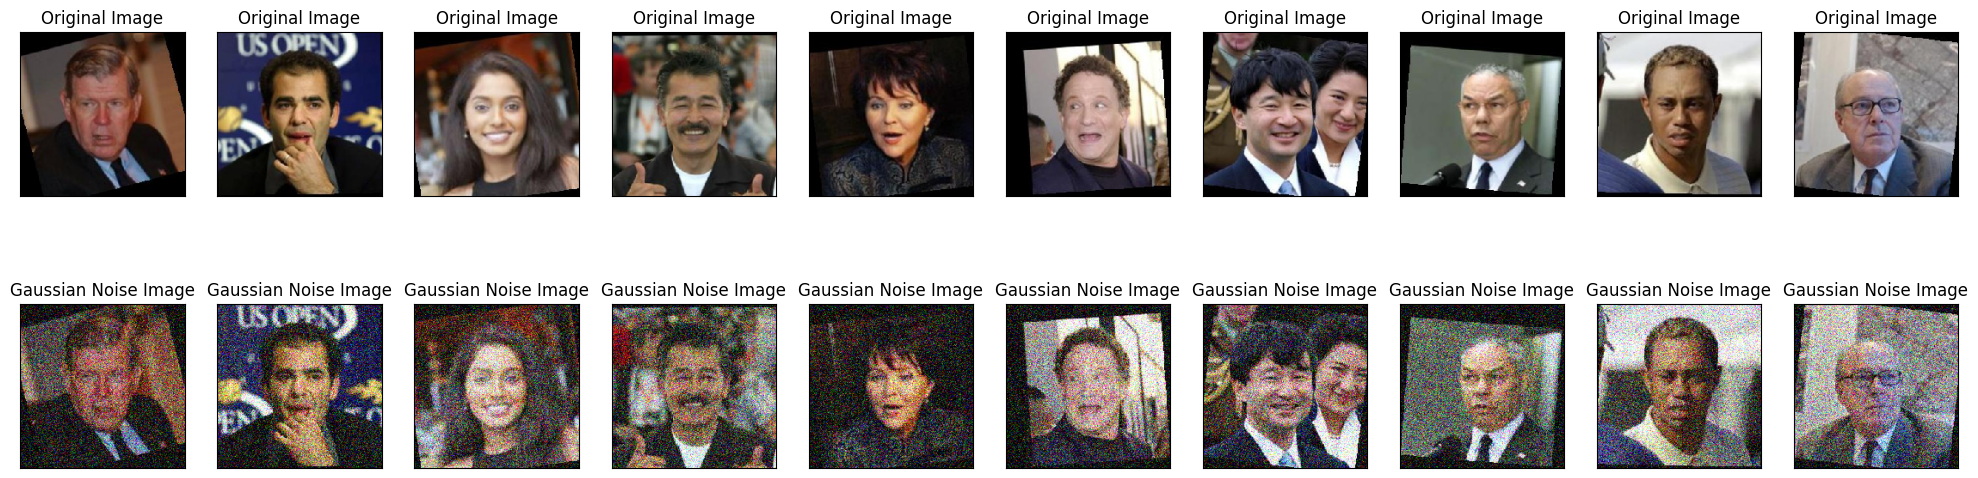

In [4]:
n = 10
plt.figure(figsize= (25,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  index = np.random.randint(0, len(images))
  img = tf.keras.utils.load_img(str(images[index]), target_size=(192,192,3))
  img = tf.keras.utils.img_to_array(img)/255.
  plt.imshow(img)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Original Image')
  ax = plt.subplot(3, n, i+1+n)
  noisy_image = random_noise(img, 'gaussian', var=0.05)
  plt.imshow(noisy_image)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Gaussian Noise Image')
plt.show()

# 1 Auto Encoder (AE) Denoising

We first use autoencoder to finish the denoising work. The structure of the AE is shown in the part 1.1 to 1.3. The AE include a encoder and a decoder and each of them have 6 layers. There are 186,455 trainable parameters in the AE.

## 1.1 Build encoder

In [5]:
input_img = Input(shape=(192, 192, 3))

l1 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(input_img)

l2 = MaxPooling2D(padding='same')(l1)
l2 = Dropout(0.2)(l2)

l3 = Conv2D(64, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l2)

l4 = MaxPooling2D(padding='same')(l3)
l4 = Dropout(0.2)(l4)

l5 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding='same')(l5)
l6 = Dropout(0.2)(l6)

## 1.2 Build decoder

In [6]:
l7 = UpSampling2D()(l6)
l7 = Dropout(0.2)(l7)
l8 = Conv2D(64, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l7)

l9 = UpSampling2D()(l8)
l9 = Dropout(0.2)(l9)
l10 = Conv2D(32, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = UpSampling2D()(l10)
l11 = Dropout(0.2)(l11)
l12 = Conv2D(3, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l11)

## 1.3 Setup network

In [7]:
decoded = Conv2D(3, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l12)

# Create our network
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 96, 96, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                         

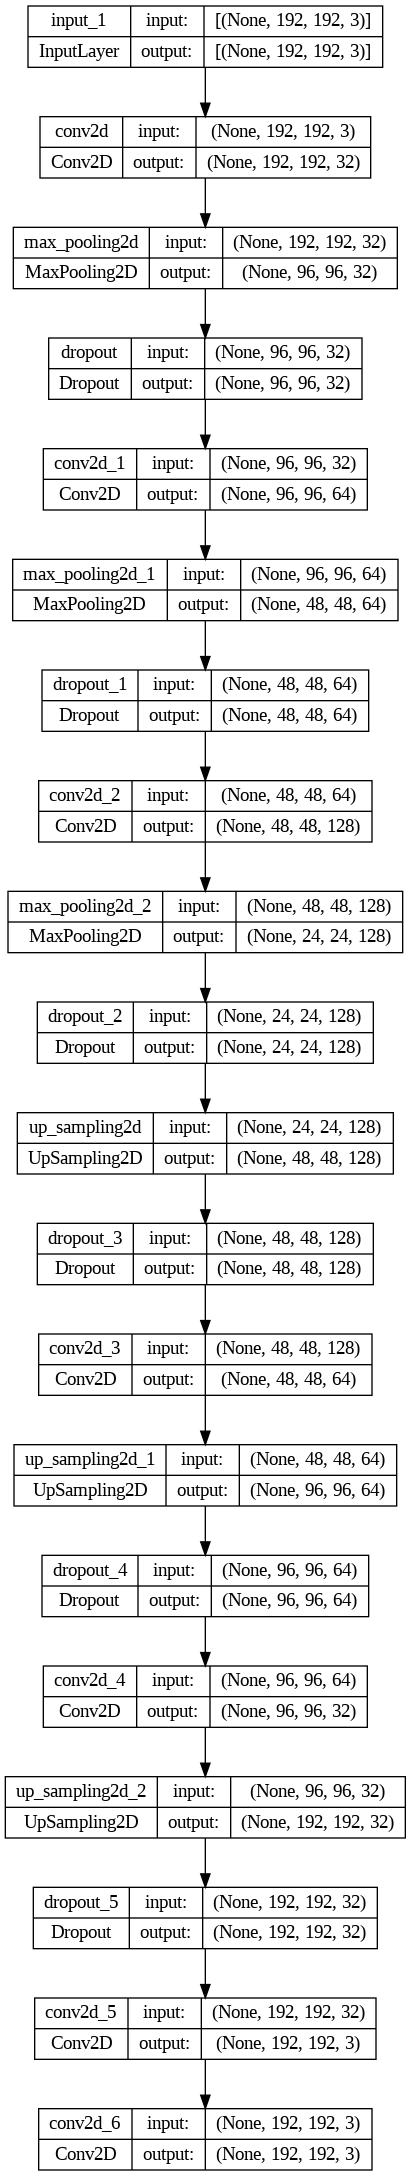

In [8]:
tf.keras.utils.plot_model(
    autoencoder,
    # to_file="AE_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    # show_layer_activations=False,
)

## 1.4 Train model

In [9]:
# Training the Model
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5,
                             min_lr=0.00001, mode='auto', cooldown=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint =  ModelCheckpoint('GN_Denoising_AE.h5', save_best_only = True, monitor="val_accuracy")
callbacks = [reduce_lr, early_stop, model_checkpoint]

In [10]:
# Training the model
x_train_n = []
x_train_noisy = []
print('Loading Train Data.....')
progress = tqdm(total = 10000, position = 0)
for x in range(10000):
  try:
      index = np.random.randint(0, len(images))
      img = tf.keras.utils.load_img(str(images[index]), target_size=(192,192,3))
      img = tf.keras.utils.img_to_array(img)/255.
      x_train_n.append(img)
      x_train_noisy.append(random_noise(img, 'gaussian', var=0.05))

      del images[index]
      progress.update(1)
  except:
      progress.update(1)
      print("Error loading image")

Loading Train Data.....


100%|██████████| 10000/10000 [41:05<00:00,  4.09it/s]

In [11]:
print("Length: ", len(x_train_n))
print('Training the model....')
history_ae = autoencoder.fit(np.array(x_train_noisy), np.array(x_train_n),
              epochs=100,
              batch_size=32,
              shuffle=True,
              validation_split=0.15,
              callbacks=callbacks)

Length:  10000
Training the model....
Epoch 1/100
266/266 [==============================] - 26s 45ms/step - loss: 0.0295 - accuracy: 0.5184 - val_loss: 0.0420 - val_accuracy: 0.6720 - lr: 0.0010
Epoch 2/100
266/266 [==============================] - 8s 32ms/step - loss: 0.0107 - accuracy: 0.6646 - val_loss: 0.0220 - val_accuracy: 0.6859 - lr: 0.0010
Epoch 3/100
266/266 [==============================] - 8s 32ms/step - loss: 0.0074 - accuracy: 0.6786 - val_loss: 0.0155 - val_accuracy: 0.7548 - lr: 0.0010
Epoch 4/100
266/266 [==============================] - 8s 32ms/step - loss: 0.0063 - accuracy: 0.7466 - val_loss: 0.0126 - val_accuracy: 0.7665 - lr: 0.0010
Epoch 5/100
266/266 [==============================] - 8s 31ms/step - loss: 0.0058 - accuracy: 0.7498 - val_loss: 0.0120 - val_accuracy: 0.7713 - lr: 0.0010
Epoch 6/100
266/266 [==============================] - 8s 31ms/step - loss: 0.0055 - accuracy: 0.7526 - val_loss: 0.0107 - val_accuracy: 0.7728 - lr: 0.0010
Epoch 7/100
266/266

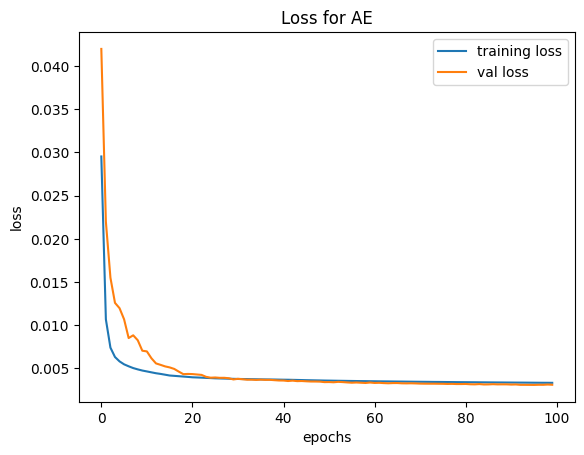

In [12]:
# Plotting graphs for loss
plt.plot(history_ae.history['loss'], label='training loss')
plt.plot(history_ae.history['val_loss'], label='val loss')
plt.title('Loss for AE')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

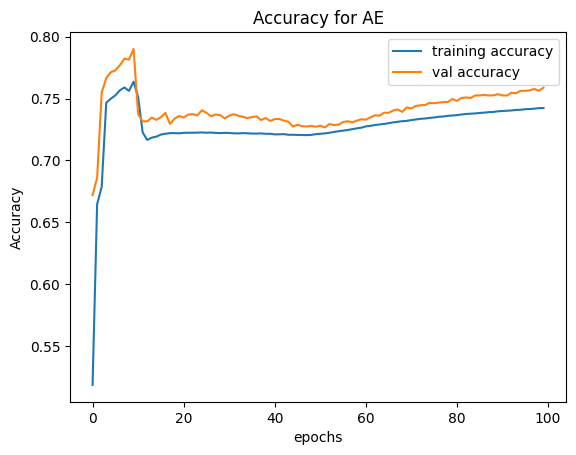

In [13]:
# Plotting graphs for accuracy
plt.plot(history_ae.history['accuracy'], label='training accuracy')
plt.plot(history_ae.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy for AE')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

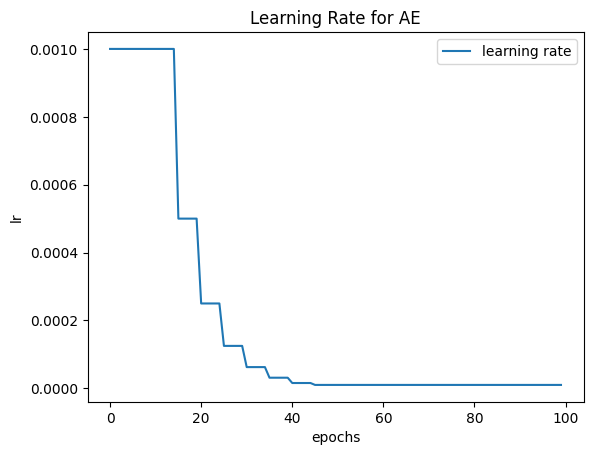

In [14]:
# Plotting graphs for lr
plt.plot(history_ae.history['lr'], label='learning rate')
plt.title('Learning Rate for AE')
plt.xlabel('epochs')
plt.ylabel('lr')
plt.legend()
plt.show()


## 1.5 Test model

In [15]:
x_test_n = []
x_test_noisy = []
progress = tqdm(total= len(images), position=0)
for img in images:
  img = tf.keras.utils.load_img(img, target_size=(192,192,3))
  img = tf.keras.utils.img_to_array(img)/255.
  x_test_n.append(img)
  x_test_noisy.append(random_noise(img, 'gaussian', var=0.05))
  progress.update(1)

100%|██████████| 3233/3233 [13:05<00:00,  4.90it/s]

In [16]:
#Evalutaing the model on test_data set
print('AE Loss and Accuracy on Test dataset....')
results_AE = autoencoder.evaluate(np.array(x_test_noisy), np.array(x_test_n))
predictions_AE = autoencoder.predict(np.array(x_test_noisy))

# Represeting Model as JSON String
autoencoder_json = autoencoder.to_json()
with open('GN_Denoising_AE_model.json', 'w') as json_file:
  json_file.write(autoencoder_json)

AE Loss and Accuracy on Test dataset....
102/102 [==============================] - 1s 8ms/step


The accuracy of the autoencoder is 0.7831 on the test dataset.

# 2 Convolutional Neural Network (CNN) Denoising

Now we construct a CNN model for the same image denoising task. The CNN consists of 10 layers. There are 73,811 trainable parameters, which is fewer than AE. 

## 2.1 Build CNN model

In [17]:
# Building a CNN Model
input_img = Input(shape=(192, 192, 3))
l1 = Conv2D(16, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(16, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = Dropout(0.2)(l2)

l4 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = Dropout(0.2)(l5)

l7 = Conv2D(64, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6)
l8 = Conv2D(64, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l7)
l9 = Dropout(0.2)(l8)

l10 = Conv2D(3, (3, 3), padding='same', activation=None,
                 activity_regularizer=regularizers.l1(10e-10))(l9)

# Create our network
cnn = Model(input_img, l10)

cnn.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 192, 192, 16)      448       
                                                                 
 conv2d_8 (Conv2D)           (None, 192, 192, 16)      2320      
                                                                 
 dropout_6 (Dropout)         (None, 192, 192, 16)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 192, 192, 32)      4640      
                                                                 
 conv2d_10 (Conv2D)          (None, 192, 192, 32)      9248      
                                                                 
 dropout_7 (Dropout)         (None, 192, 192, 32)      0   

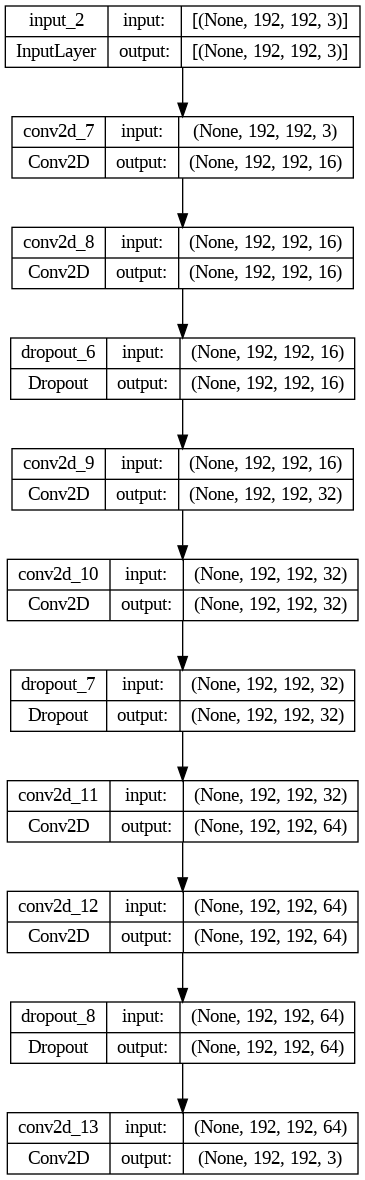

In [18]:
tf.keras.utils.plot_model(
    cnn,
    # to_file="CNN_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    # show_layer_activations=False,
)

## 2.2 Train model

In [19]:
# Training the cnn model
model_checkpoint =  ModelCheckpoint('GN_Denoising_CNN.h5', save_best_only = True, monitor="val_accuracy")
callbacks = [reduce_lr, early_stop, model_checkpoint]

print("Length: ", len(x_train_n))
print('Training the model....')
history_cnn = cnn.fit(np.array(x_train_noisy), np.array(x_train_n),
              epochs=100,
              batch_size=32,
              shuffle=True,
              validation_split=0.15,
              callbacks=callbacks)

Length:  10000
Training the model....
Epoch 1/100
266/266 [==============================] - 34s 84ms/step - loss: 0.0114 - accuracy: 0.6555 - val_loss: 0.0077 - val_accuracy: 0.7272 - lr: 0.0010
Epoch 2/100
266/266 [==============================] - 16s 59ms/step - loss: 0.0037 - accuracy: 0.7284 - val_loss: 0.0073 - val_accuracy: 0.7418 - lr: 0.0010
Epoch 3/100
266/266 [==============================] - 16s 58ms/step - loss: 0.0030 - accuracy: 0.7408 - val_loss: 0.0073 - val_accuracy: 0.7627 - lr: 0.0010
Epoch 4/100
266/266 [==============================] - 15s 58ms/step - loss: 0.0028 - accuracy: 0.7550 - val_loss: 0.0056 - val_accuracy: 0.7674 - lr: 0.0010
Epoch 5/100
266/266 [==============================] - 16s 58ms/step - loss: 0.0026 - accuracy: 0.7639 - val_loss: 0.0060 - val_accuracy: 0.7622 - lr: 0.0010
Epoch 6/100
266/266 [==============================] - 16s 58ms/step - loss: 0.0025 - accuracy: 0.7698 - val_loss: 0.0049 - val_accuracy: 0.8072 - lr: 0.0010
Epoch 7/100
26

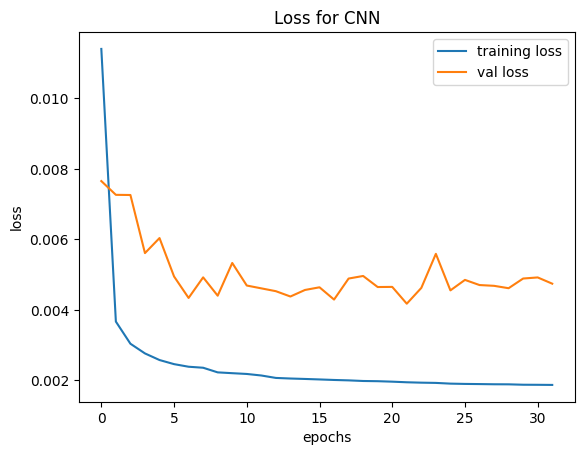

In [20]:
# Plotting graphs for loss
plt.plot(history_cnn.history['loss'], label='training loss')
plt.plot(history_cnn.history['val_loss'], label='val loss')
plt.title('Loss for CNN')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

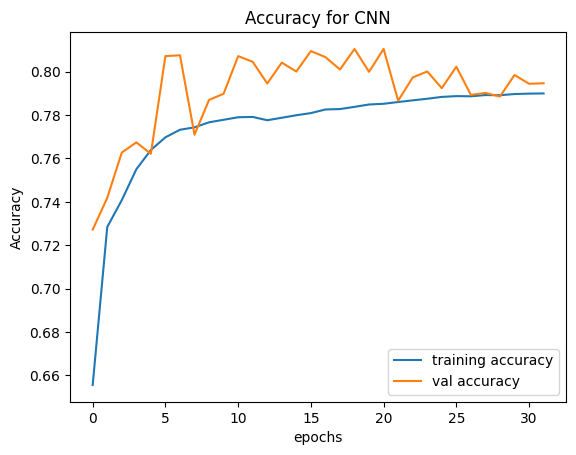

In [21]:
# Plotting graphs for accuracy
plt.plot(history_cnn.history['accuracy'], label='training accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy for CNN')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

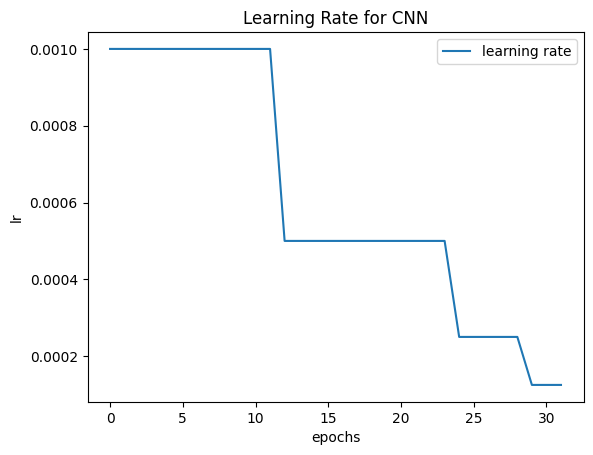

In [22]:
# Plotting graphs for lr
plt.plot(history_cnn.history['lr'], label='learning rate')
plt.title('Learning Rate for CNN')
plt.xlabel('epochs')
plt.ylabel('lr')
plt.legend()
plt.show()

## 2.3 Test model

In [23]:
#Evalutaing the model on test_data set
print('CNN Loss and Accuracy on Test dataset...')
results_CNN = cnn.evaluate(np.array(x_test_noisy), np.array(x_test_n))
predictions_CNN = cnn.predict(np.array(x_test_noisy))

# Represeting Model as JSON String
cnn_json = cnn.to_json()
with open('GN_Denoising_CNN_model.json', 'w') as json_file:
  json_file.write(cnn_json)

CNN Loss and Accuracy on Test dataset...
102/102 [==============================] - 1s 13ms/step


The accuracy of CNN is 0.8083, which is even higher than AE.

# 3 Comparison between AE and CNN denoising

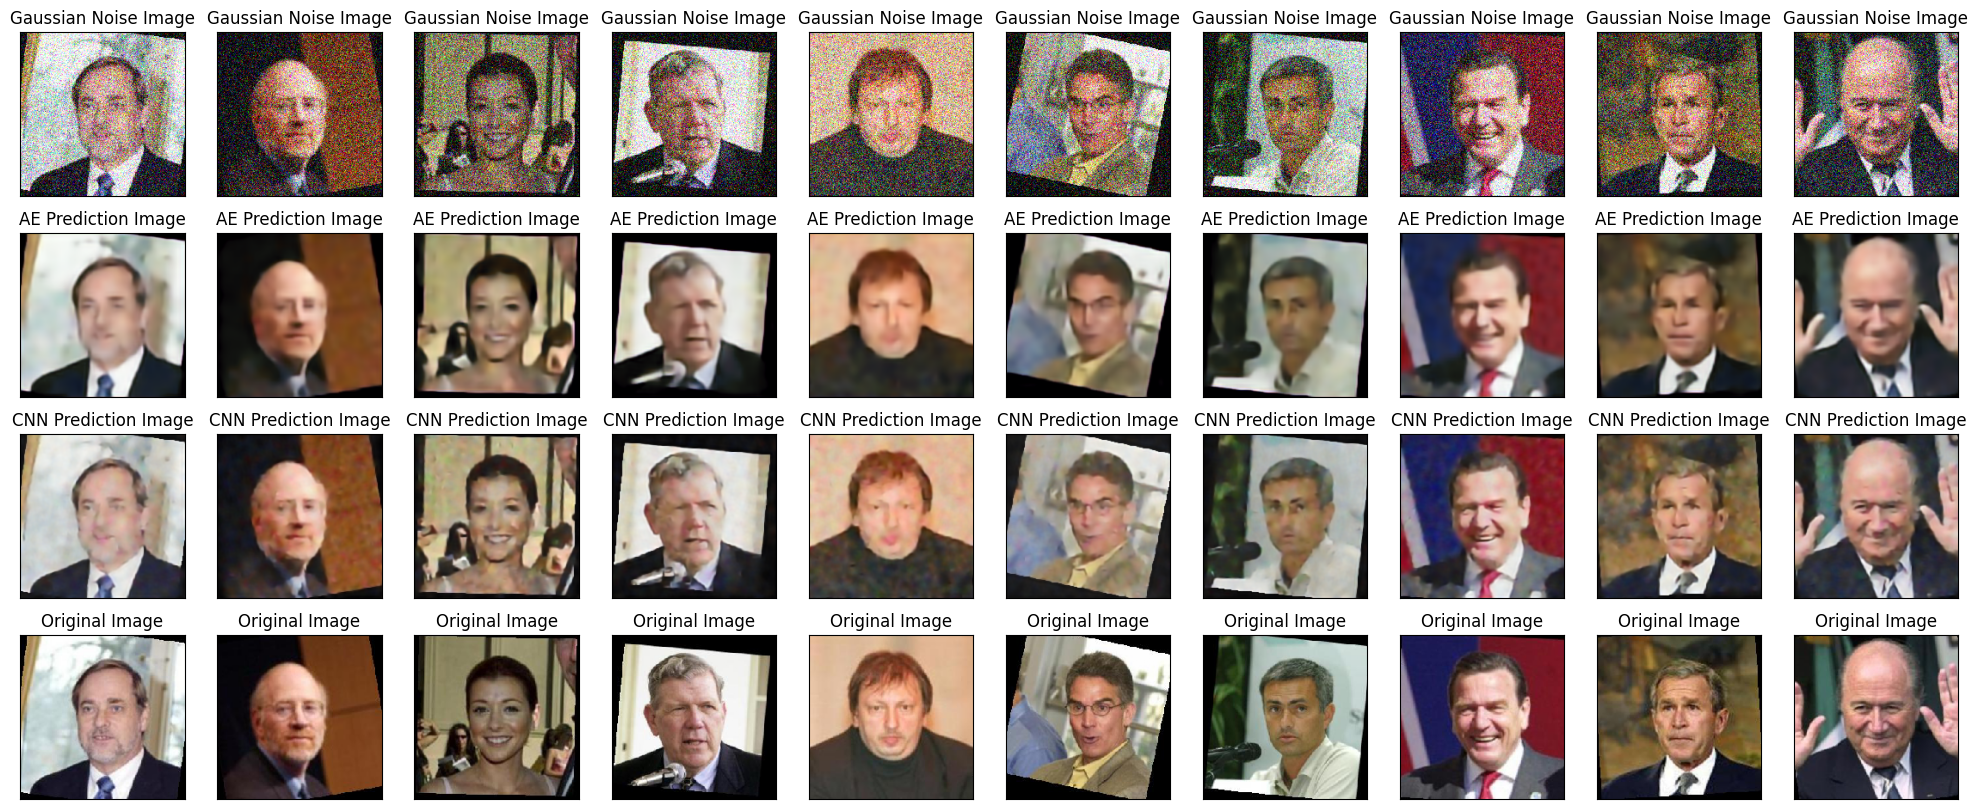

In [24]:
n = 10
plt.figure(figsize= (25,10))
for i in range(n):
  ax = plt.subplot(4, n, i+1)
  index = np.random.randint(0, len(x_test_n))
  act_img = tf.keras.utils.array_to_img(x_test_noisy[index])
  plt.imshow(act_img, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Gaussian Noise Image')
  ax = plt.subplot(4, n, i+1+n)
  pred_ae = tf.keras.utils.array_to_img(predictions_AE[index])
  plt.imshow(pred_ae, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('AE Prediction Image')
  ax = plt.subplot(4, n, i+11+n)
  pred_cnn = tf.keras.utils.array_to_img(predictions_CNN[index])
  plt.imshow(pred_cnn, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('CNN Prediction Image')
  ax = plt.subplot(4, n, i+21+n)
  plt.imshow(x_test_n[index])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Original Image')
plt.show()

It can be seen that although GNN can obtain a higher accuracy, from our human point of view, the AE result is somehow better than CNN result since it seems to capture more details although the accuracy is lower due to some shift of reconstruction. 

We then test the two models on a different test set to test their generalization performance. Here are 5 images that picked from other datasets, which has not been seen by the model. We would test our two models on them and compare the accuracies.

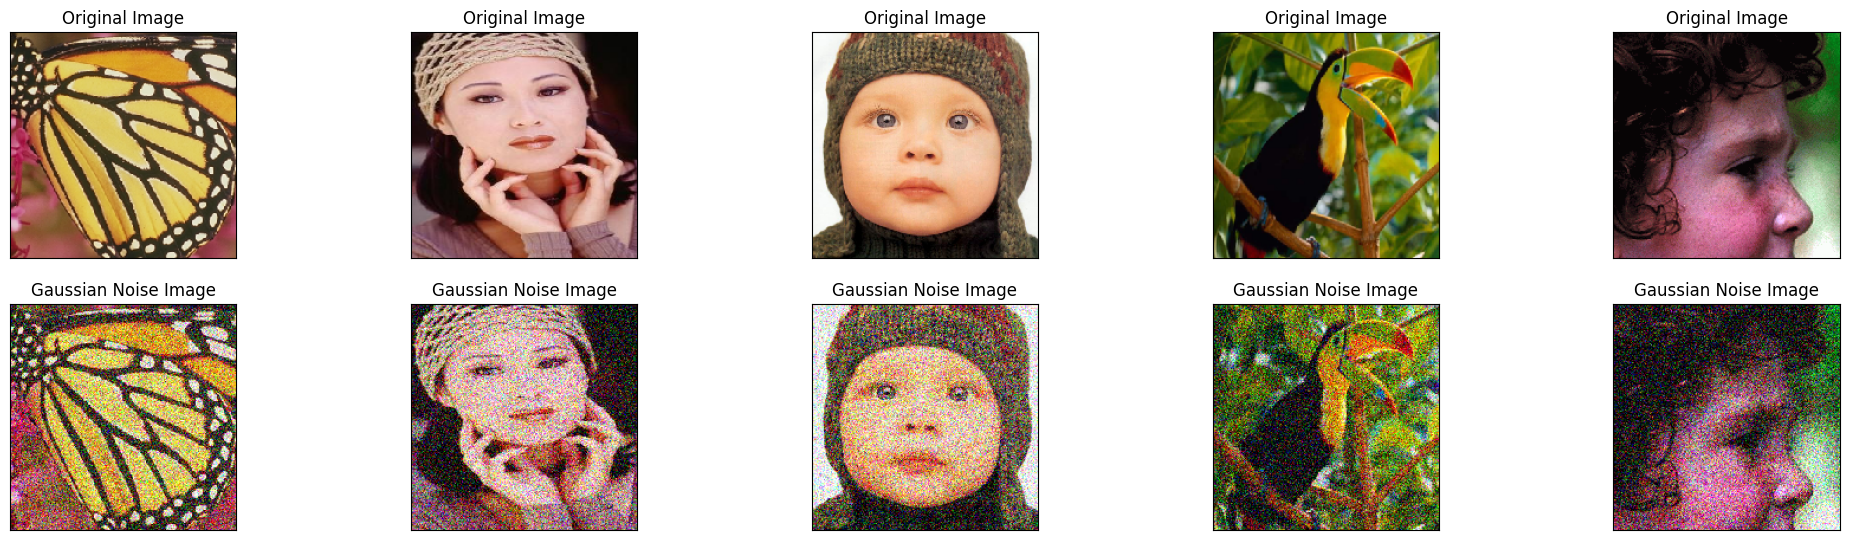

In [25]:
test_images = glob.glob('./drive/MyDrive/Graph_Denoising/test-images/*.jpg')
n = len(test_images)
plt.figure(figsize= (25,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  index = i
  img = tf.keras.utils.load_img(str(test_images[index]), target_size=(192,192,3))
  img = tf.keras.utils.img_to_array(img)/255.
  plt.imshow(img)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Original Image')
  ax = plt.subplot(3, n, i+1+n)
  noisy_image = random_noise(img, 'gaussian', var=0.05)
  plt.imshow(noisy_image)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Gaussian Noise Image')
plt.show()

In [26]:
test_n = []
test_noisy = []
progress = tqdm(total= len(test_images), position=0)
for img in test_images:
  img = tf.keras.utils.load_img(img, target_size=(192,192,3))
  img = tf.keras.utils.img_to_array(img)/255.
  test_n.append(img)
  test_noisy.append(random_noise(img, 'gaussian', var=0.05))
  progress.update(1)

  0%|          | 0/5 [00:00<?, ?it/s]

In [27]:
#Evalutaing the model on test_data set
print('AE Loss and Accuracy on Test images....')
results_AE = autoencoder.evaluate(np.array(test_noisy), np.array(test_n))
predictions_AE = autoencoder.predict(np.array(test_noisy))

# Represeting Model as JSON String
autoencoder_json = autoencoder.to_json()
with open('GN_Denoising_AE_model.json', 'w') as json_file:
  json_file.write(autoencoder_json)

100%|██████████| 3233/3233 [22:19<00:00,  2.41it/s]


AE Loss and Accuracy on Test images....
1/1 [==============================] - 0s 34ms/step


In [28]:
#Evalutaing the model on test_data set
print('CNN Loss and Accuracy on Test dataset...')
results_CNN = cnn.evaluate(np.array(test_noisy), np.array(test_n))
predictions_CNN = cnn.predict(np.array(test_noisy))

# Represeting Model as JSON String
cnn_json = cnn.to_json()
with open('GN_Denoising_CNN_model.json', 'w') as json_file:
  json_file.write(cnn_json)

CNN Loss and Accuracy on Test dataset...
1/1 [==============================] - 0s 22ms/step


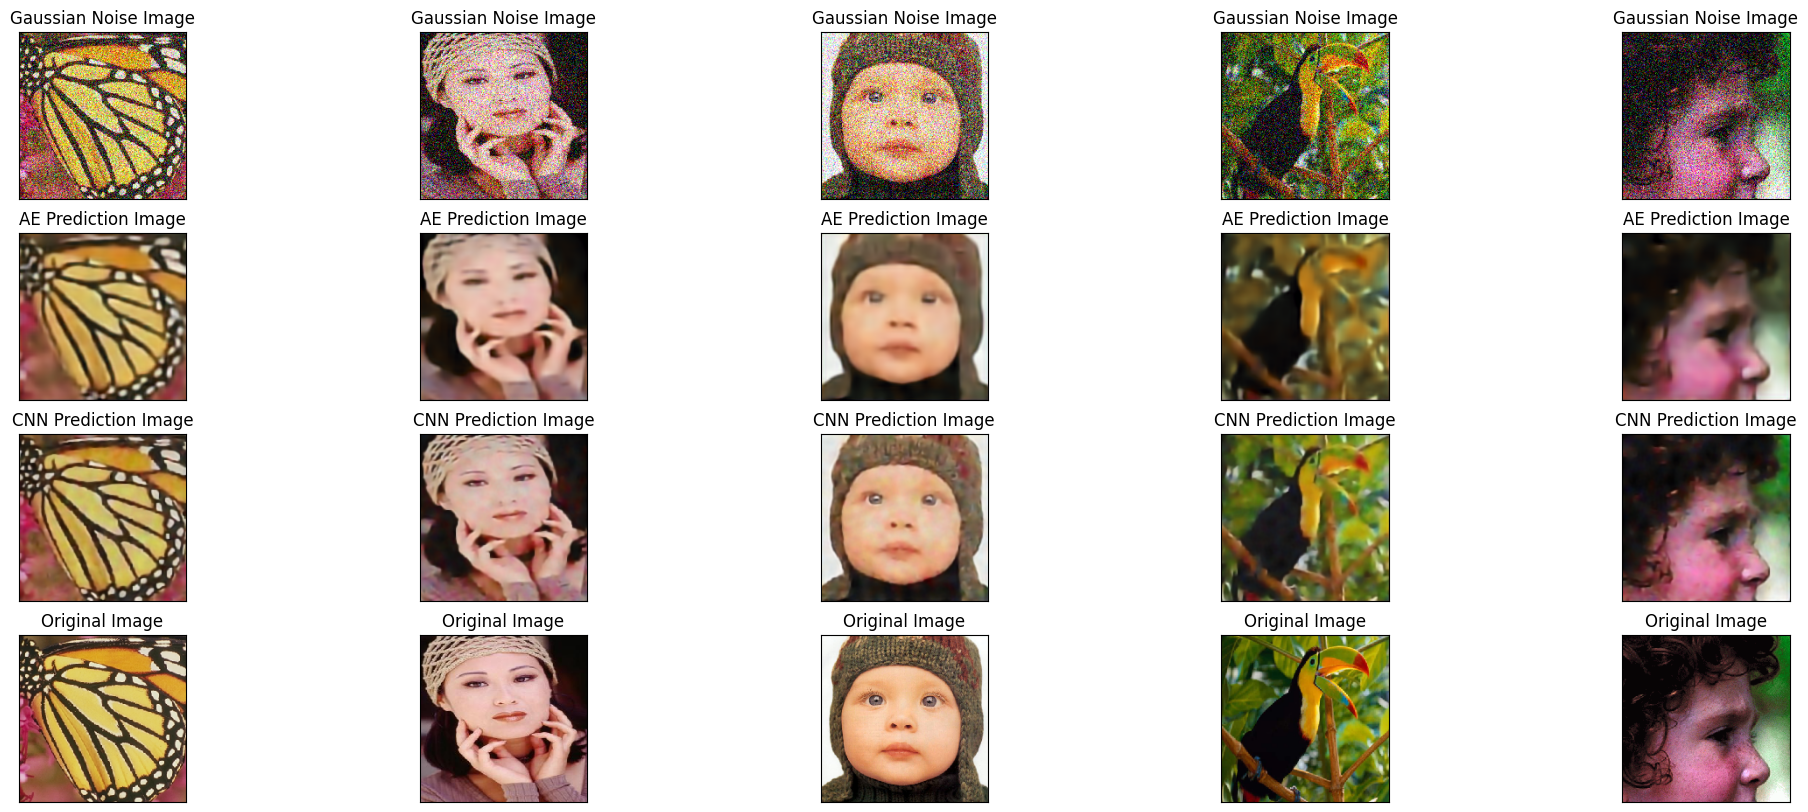

In [31]:
n = 5
plt.figure(figsize= (25,10))
for i in range(n):
  ax = plt.subplot(4, n, i+1)
  index = i
  act_img = tf.keras.utils.array_to_img(test_noisy[index])
  plt.imshow(act_img, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Gaussian Noise Image')
  ax = plt.subplot(4, n, i+1+n)
  pred_ae = tf.keras.utils.array_to_img(predictions_AE[index])
  plt.imshow(pred_ae, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('AE Prediction Image')
  ax = plt.subplot(4, n, i+6+n)
  pred_cnn = tf.keras.utils.array_to_img(predictions_CNN[index])
  plt.imshow(pred_cnn, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('CNN Prediction Image')
  ax = plt.subplot(4, n, i+11+n)
  plt.imshow(test_n[index])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Original Image')
plt.show()

Alright! Let's see, the accuracy of CNN is higher than autoencoder, and from the figure groups above, it's obvious that CNN seems to be better since it's results show clearer outlines and the results from AE seems to be nebulous. Here I would like to say CNN is the winner!